## Simple implementation of model quantification
Mainly includes post-quantization (PTQ) and perceptual quantization (QAT)

SeonWoo Lee：
- github repository： https://github.com/LEE-SEON-WOO/deployment-with-CMSIS-NN

### 1. Implementation of post-quantization

Quantization involves converting real numbers into low-bit integers. The conversion formula is:
$$r= S(q-Z)$$
$$q=round(\frac{r}{S}+Z)$$
The key to post-quantization is to calculate scale (the scaling ratio of real numbers and integers) and zero point (the integer corresponding to the quantized real number 0).
$$S=\frac{r_{\max }-r_{\min }}{q_{\max }-q_{\min }}$$
$$ Z = round(q_{\max}-\frac{r_{max}}{S})$$
The following code is used to implement these two parts to complete basic tensor quantization.
When $Z>q_{\max}$ or $Z<q_{\min}$ appears, Z needs to be truncated (because Z is also stored in uint).
At this time, it can be deduced that $r_{\max}<0$ or $r_{\min}>0$, so we should try to avoid the situation where tensors are all positive or negative numbers.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

c:\Users\hci-lab01\.conda\envs\mcu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 기본 양자화 연산 구현

In [2]:
def getScaleZeroPoint(min_val,max_val,num_bits=8):
    """
    양자화 매개변수 스케일 및 영점 계산
    @param
        min_val: 실제 최대값
        max_val: 실제 최소값
        num_bits: 양자화 비트 수

    @return
        scale: 실수 정수 스케일링 비율
        zero_point: 양자화된 영점
    """
    #여기에 입력된 mix_val과 max_val은 스칼라라는 점에 유의하세요.
    q_min = -2. ** (num_bits) #부호 있는 숫자로 양자화[-128,127] 또는 부호 없는 숫자로 양자화[0,255]
    q_max = 2. ** num_bits - 1
    """
    여기서는 qmax와 qmin의 차이가 주로 사용됩니다.
    실수와 양자화된 숫자의 범위 비율은 스케일이며,
    rmax와 qmax의 스케일링된 수의 차이가 영점입니다.
    따라서 q_min과 q_max 값 자체는 중요하지 않습니다.
    """
    scale = (max_val-min_val) / (q_max-q_min)
    zero_point = q_max - max_val/scale

    # 왜 zero_point를 자르나요? 영점도 uint8에 저장되기 때문입니다.
    if zero_point < q_min:
        zero_point = torch.tensor([q_min], dtype=torch.float32).to(min_val.device)
    elif zero_point > q_max:
        # zero_point = qmax
        zero_point = torch.tensor([q_max], dtype=torch.float32).to(max_val.device)
    
    zero_point.round_()

    return scale,zero_point

def quantize_tensor(x,scale,zero_point,num_bits=8,signed=False):
    """
    텐서 x 양자화
    @param:
        x: 양자화할 부동 소수점 수의 텐서
        scale, zero_point: 양자화 매개변수
        num_bits: 양자화 비트 수
        signed: 부호 있는 양자화 사용
    @return:
        q_x: 정수로 양자화된 텐서
    """
    if signed: #부호 있는 숫자로 양자화[-128,127]
        q_min = - 2. ** (num_bits-1)
        q_max = 2. ** (num_bits-1) - 1
    else:  #부호 없는 숫자로 양자화[0,255]
        q_min = 0.
        q_max = 2. ** num_bits - 1 
    
    q_x = x/scale + zero_point
    # 잘림 및 반올림을 위해 pytorch 내장 함수를 사용합니다. 이 선은 공식 round 함수와 동일합니다.
    q_x.clamp_(q_min,q_max).round_() 

    return q_x

def dequantize_tensor(q_x,scale,zero_point):
    """
    양자화된 텐서 q_x를 부동 소수점 텐서 x로 역양자화
    @param:
        q_x: 정수로 양자화된 텐서
        scale, zero_point: 양자화 매개변수
    @return:
         양자화 전 부동 소수점 텐서 x
    """
    return scale * (q_x - zero_point) 

In [3]:
x = torch.tensor([-10.0,20.1,23.4,0.1,13.3])
scale,zero_point = getScaleZeroPoint(x.min(),x.max(),8)
q_x = quantize_tensor(x,scale,zero_point)
deq_x = dequantize_tensor(q_x,scale,zero_point)

print("scale={:.3f},zero_point={}".format(scale,zero_point))
print("q_x={}".format(q_x))
print("deq_x={}".format(deq_x))
print("error={}".format(deq_x-x))   #양자화 오류


scale=0.065,zero_point=-103.0
q_x=tensor([  0., 205., 255.,   0., 100.])
deq_x=tensor([ 6.7323, 20.1315, 23.3996,  6.7323, 13.2685])
error=tensor([ 1.6732e+01,  3.1507e-02, -3.9101e-04,  6.6323e+00, -3.1507e-02])


### Q-format (Q7.0) : 7-bit fractional part in CMSIS-NN library
```python
min_wt = weight.min() 
max_wt = weight.max()

#find number of integer bits to represent this range
int_bits = int(np.ceil(np.log2(max(abs(min_wt),abs(max_wt))))) 
frac_bits = 7-int_bits #remaining bits are fractional bits (1-bit for sign)

#floating point weights are scaled and rounded to [-128,127], which are used in 
#the fixed-point operations on the actual hardware (i.e., microcontroller)
quant_weight = np.round(weight*(2**frac_bits))

#To quantify the impact of quantized weights, scale them back to
# original range to run inference using quantized weights
weight = quant_weight/(2**frac_bits)

```

In [4]:
def compute_fractional_bits(min_value, max_value):
    return int(torch.ceil(torch.log2(torch.max(torch.abs(max_value), torch.abs(min_value)))).item())

def quantize_qtensor(weight):
    q_frac = compute_fractional_bits_tensor(weight)
    return torch.ceil(weight*(2**q_frac)).type(torch.int8)

def dequantize_qtensor(weight, q_frac):
    return weight / (2**q_frac)

def compute_fractional_bits_tensor(weight, weight_bits=8):
    return weight_bits - 1 - compute_fractional_bits(torch.min(weight), torch.max(weight))



#### Implementation of quantified parameter class

양자화 과정에서 가중치와 활성화 값 텐서의 최대-최소 정보를 계산하고 해당 스케일과 영점을 계산하여 양자화 작업을 수행해야 합니다.
저장할 매개변수와 사용할 양자화 연산을 클래스, 즉 양자화 매개변수로 캡슐화할 수 있습니다.
양자화 알고리즘의 핵심은 양자화 매개변수를 결정하는 것이기도 합니다.

In [5]:
class QParam(nn.Module):
    # 위의 코드를 캡슐화하면 됩니다.
    # 상속 모듈은 양자화(매개변수)를 네트워크의 일부로 만드는 것입니다.
    def __init__(self,num_bits=8):
        super().__init__()

        self.num_bits = num_bits
        scale = torch.tensor([], requires_grad=False)
        zero_point = torch.tensor([], requires_grad=False)
        min = torch.tensor([], requires_grad=False)
        max = torch.tensor([], requires_grad=False)
        
        # 양자화 매개변수를 저장하기 위해 Register_buffer를 사용하면 다음과 같은 장점이 있습니다.
        # 그래디언트는 생성되지 않으며 매개변수에 등록되지 않지만 state_dict에도 저장됩니다.
        # 이러한 방식으로 모델 가중치와 양자화 매개변수를 모델에 독립적으로 저장할 수 있습니다.
        self.register_buffer('scale', scale)  
        self.register_buffer('zero_point', zero_point)
        self.register_buffer('min', min)
        self.register_buffer('max', max)
        
    def update(self,tensor):
        # 입력 텐서를 양자화하려면 해당 양자화 매개변수를 업데이트합니다.
        if self.max.nelement() == 0 or self.max <tensor.max():
            self.max.data = tensor.max().data   #Use data assignment to avoid the self.max object itself
        self.max.clamp_(min=0)  # self.max가 0보다 크거나 같은지 확인

        if self.min.nelement() == 0  or self.min >tensor.min():
            self.min.data = tensor.min().data
        self.min.clamp_(max=0)  # self.min이 0보다 작거나 같은지 확인

        self.scale,self.zero_point = getScaleZeroPoint(self.min, self.max, self.num_bits)
    
    def quantize_tensor(self,tensor):
        return quantize_tensor(tensor,self.scale,self.zero_point,self.num_bits)
        
    def dequantize_tensor(self,q_x):
        return dequantize_tensor(q_x,self.scale,self.zero_point)

    # Load quantization parameters from 'state_dict'
    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs):
        key_names = ['scale', 'zero_point', 'min', 'max']
        for key in key_names:
            value = getattr(self, key)
            value.data = state_dict[prefix + key].data
            state_dict.pop(prefix + key)

    def __str__(self):
        info = 'scale:%.10f '  % self.scale
        info += 'zero_point:%d '  % self.zero_point
        info += 'min:%.6f '  % self.min
        info += 'max:%.6f'  % self.max
        return info


In [6]:
q_parm = QParam(num_bits=8)
x = torch.tensor([-10.0,20.1,23.4,0.1,13.3])
q_parm.update(x)
print("q_x=",q_parm.quantize_tensor(x))
print("q_parm:",q_parm)  #Print quantization parameters
print("q_parm state dict:",q_parm.state_dict()) #Print state dictionary
torch.save(q_parm.state_dict(),"./q_parm.pt")# Save state dictionary

q_parm_new = QParam(num_bits=8)  #Create a new quantization parameter object
q_parm_new.load_state_dict(torch.load("./q_parm.pt")) #Load quantization parameters from saved state dictionary
print("q_parm_new",q_parm_new)  #Print the quantization parameters to see if they are consistent

q_x= tensor([  0., 205., 255.,   0., 100.])
q_parm: scale:0.0653620362 zero_point:-103 min:-10.000000 max:23.400000
q_parm state dict: OrderedDict([('scale', tensor(0.0654)), ('zero_point', tensor(-103.)), ('min', tensor(-10.)), ('max', tensor(23.4000))])
q_parm_new scale:0.0653620362 zero_point:-103 min:-10.000000 max:23.400000


#### Quantitative network module

위에서 우리는 텐서를 양자화할 수 있었지만 데이터 수준에서만 가능했습니다.
또한 신경망의 모듈과 동작을 정량화하고, 정량화에 적합한 네트워크 계층을 설정해야 합니다. (conv,relu,maxpooling,fc 등)

컨볼루션의 가중치를 w, 편향을 b, 입력을 x, 출력 활성화 값을 a라고 가정합니다. 컨볼루션은 기본적으로 행렬 연산이므로 다음과 같이 표현할 수 있습니다.
$$ a=\sum_{i}^{N} w_{i} x_{i}+b$$  
양자화 공식은 다음과 같습니다.
$$ S_{a}\left(q_{a}-Z_{a}\right)=\sum_{i}^{N} S_{w}\left(q_{w}-Z_{w}\right) S_{x}\left(q_{x}-Z_{x}\right)+S_{b}\left(q_{b}-Z_{b}\right)$$
$$ q_{a}=\frac{S_{w} S_{x}}{S_{a}} \sum_{i}^{N}\left(q_{w}-Z_{w}\right)\left(q_{x}-Z_{x}\right)+\frac{S_{b}}{S_{a}}\left(q_{b}-Z_{b}\right)+Z_{a}$$
그 중에서 $M=\frac{S_{w} S_{x}}{S_{a}}$으로 결정되고, 일반적으로 $Z_{b}=0$으로 가정하면 다음과 같이 표현할 수 있습니다.
$$q_{a} = M\left(\sum_{i}^{N} q_{w} q_{x}-\sum_{i}^{N} q_{w} Z_{x}-\sum_{i}^{N} q_{x} Z_{w}+\sum_{i}^{N} Z_{w} Z_{x}+q_{b}\right)+Z_{a}$$

위에서 알 수 있듯이 x가 동적 입력이라는 점을 제외하면，$q_{w}q_{x}$ 및 $q_{w}Z_{x}$ 는 알 수 없으며 다른 계산 결과는 미리 결정될 수 있습니다.
십진수인 M을 제외하고 나머지는 모두 정수이며 M은 비트 이동을 통해 고정 소수점 곱셈을 구현할 수 있습니다.
따라서 위 방정식은 정수 고정 소수점 연산을 사용하여 완성될 수 있습니다.

In [7]:
from abc import abstractmethod
from torch.autograd import Variable
from torch.autograd import Function

import math

class QModule(nn.Module):
    # 다양한 네트워크 모듈 기본 클래스 생성 및 코드 재사용

    def __init__(self,qi=True,qo=True,num_bits=8):
        super().__init__()  #상위 클래스의 생성자를 호출합니다.
        """
        네트워크 모듈의 핵심은 데이터 a = f(x)에 대한 연산자입니다. 또한 x를 입력하고 a의 양자화 매개변수를 출력해야 합니다.
        그러나 모든 모듈에 입력이 있는 것은 아니므로 이전 레이어의 qo를 이 레이어의 qi로 사용해야 합니다.

        qi: S_x, Z_x를 포함하여 이 레이어에 입력되는 양자화 매개변수
        qo: S_a, Z_a를 포함하여 이 레이어에서 출력되는 양자화 매개변수
        """
        if qi:
            self.qi = QParam(num_bits=num_bits)
        if qo:
            self.qo = QParam(num_bits=num_bits)
        
    def freeze(self):
        # 계산할 수 있는 정적 결과를 동결하고 이를 부동 소수점 실수에서 고정 소수점 정수로 변환합니다.
        pass

    @abstractmethod
    def quantize_inference(self,x):
        # 정량적 추론은 일반적인 추론 과정과 일치하지 않으며 다시 작성해야 하므로 가상 함수로 정의됩니다.
        raise NotImplemented("quantize_inference should be implemented.")

class FakeQuantize(Function):
    # Fake 양자화 노드, 양자화 및 역양자화 수행
    # 양자화 전후의 오류를 시뮬레이션합니다. 이러한 부동 추론은 양자화 int 추론과 동일한 정확도를 갖습니다.

    # 역전파를 통해 기울기를 구하려면 STE를 사용하세요.이 부분은 PTQ에서 역전파되지 않으므로 당분간 무시해도 됩니다.
    # Function Class는 매개변수가 없는 모듈과 유사합니다. 상속을 위해서는 순방향 및 역방향를 다시 작성해야 합니다.
    @staticmethod
    def forward(ctx, x, qparam):
        """
        def forward(ctx,input,*args)
            ctx: 수동으로 전달할 필요가 없습니다. 다음과 같은 몇 가지 작업을 수행하여 기울기 계산을 용이하게 할 수 있습니다.
            ctx.save_for_backward(tensor)  순방향 전파 중에 일부 텐서를 저장합니다.
            tensor = ctx.saved_tensors    역전파 중에도 액세스할 수 있습니다(역방향 함수 내부).

            input:함수 입력
            *args:기타 선택적 매개변수
        """
        x = qparam.quantize_tensor(x)
        x = qparam.dequantize_tensor(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        """
        grad_output:다음 레이어의 기울기

        QAT에서는 역전파(backpropagation)에 관한 것입니다.
        이 레이어(Fake 양자화 노드)의 경우 기울기가 계산되지 않고 다음 레이어의 기울기가 직접 전달됩니다.

        backward의 반환 값은 해당 입력의 기울기를 나타내는 전달 값과 일치해야 합니다.
        q_parm은 양자화 매개변수이므로 기울기를 계산할 필요가 없으므로 None이 반환됩니다.
        따라서 grad_output,None을 직접 반환합니다.
        """
        return grad_output, None


In [8]:
class QConv2d(QModule):
    # 2D 컨볼루션 연산의 양자화된 버전
    def __init__(self,conv_module,qi=True,qo=True,num_bits=8):
        # 상위 클래스의 속성 구성
        super().__init__(qi=qi,qo=qo,num_bits=num_bits)
        self.conv_module = conv_module    #양자화되지 않은 완전 정밀도 컨볼루션 모듈을 전달합니다.
        self.qw = QParam(num_bits=num_bits)  #컨벌루션 레이어 가중치의 양자화 매개변수
        self.num_bits = num_bits
    
    def freeze(self,qi=None,qo=None):
        # 수식에서 M, q_w 및 q_b를 계산하고 고정하려면
        # 양자화된 컨볼루션 레이어는 qi와 qo가 모두 존재하고 한 번만 초기화되도록 보장해야 합니다.
        if hasattr(self,'qi') and qi is not None:
            raise ValueError("qi has been provided in init function.")

        if not hasattr(self,'qi') and qi in None:
            raise ValueError("qi is not existed, should be provided.")
        
        if hasattr(self, 'qo') and qo is not None:
            raise ValueError('qo has been provided in init function.')

        if not hasattr(self, 'qo') and qo is None:
            raise ValueError('qo is not existed, should be provided.')
        
        if qi: 
            self.qi = qi
        if qo: 
            self.qo = qo

        # M = S_w*S_x / S_a 
        self.M = self.qw.scale*self.qi.scale / self.qo.scale
        
        # 컨벌루션 커널 매개변수 q_w를 고정 소수점 정수 저장 장치로 양자화
        self.conv_module.weight.data = self.qw.quantize_tensor(self.conv_module.weight.data) 
        #  zero_point를 빼는 이유는 실제로 해당 수식에서는 q_w-Z_w입니다.
        self.conv_module.weight.data = self.conv_module.weight.data - self.qw.zero_point

        # 편의상 S_b 대신 S_w*S_x를 사용합니다.
        # 편향을 위해 대칭 양자화를 사용합니다. Z_b=0 (실수 0은 양자화 후 0과 동일합니다)
        # 컨볼루션 연산의 결과는 일반적으로 32비트를 사용하여 저장되므로 바이어스도 32비트 양자화를 사용합니다.
        self.conv_module.bias.data = quantize_tensor(self.conv_module.bias.data,scale=self.qi.scale*self.qw.scale,zero_point=0,num_bits=32,signed=True)

    def forward(self,x):
        # QAT의 역전파에 적합한 fake 양자화 순방향 추론 함수
        # 추론 과정에서 입력 x, 출력 a, 가중치 w의 정량적 매개변수를 통계적으로 계산합니다.
        # post-quantization는 데이터 교정을 통해 이를 달성합니다.

        if hasattr(self,'qi'):
            self.qi.update(x)  #更新q_x的量化参数
            x = FakeQuantize.apply(x, self.qi)  #fake 양자화 q_x

        self.qw.update(self.conv_module.weight.data) #q_w의 양자화 매개변수 업데이트

        # 컨볼루션 가중치 q_w에 대해 fake 양자화를 수행한 다음 x를 사용하여 컨볼루션 연산을 계산합니다.
        # 컨볼루션 모듈의 가중치는 항상 원래 가중치를 저장하고 순방향 전파 중에만 fake 양자화된다는 점에 유의하세요.
        # 역전파 중에는 양자화 전 가중치도 업데이트됩니다.
        x = F.conv2d(x, FakeQuantize.apply(self.conv_module.weight, self.qw), self.conv_module.bias, 
                     stride=self.conv_module.stride,
                     padding=self.conv_module.padding, dilation=self.conv_module.dilation, 
                     groups=self.conv_module.groups)

        x = self.conv_module(x)

        if hasattr(self,'op'):
            self.qo.update(x) #출력 q_a의 양자화 매개변수 업데이트
            x = FakeQuantize.apply(x, self.qo)  #출력 a를 fake 양자화
        
        return x
    
    def quantize_inference(self,x):
        # 가중치와 활성화 값을 양자화한 후 추론
        # Pytorch 플랫폼의 한계로 인해 float는 정수를 저장하고 부동 소수점 연산을 수행하는 데 사용됩니다.
        # 실제 배포 중에 모든 데이터와 작업은 고정 소수점 정수를 사용해야 합니다(계산).
        x = x - self.qi.zero_point  #q_x - Z_x
        x = self.conv_module(x)    #(q_w-Z_w)*(q_x-Z_x)
        x = self.M * x             #M*sum((q_w-Z_w)*(q_x-Z_x))
        x.round_()                 #프로세스 속도를 높이려면 미리 라운드를 수행하십시오. 정수 덧셈이 하나만 남았습니다.
        x = x + self.qo.zero_point   #M*sum((q_w-Z_w)*(q_x-Z_x))+Z_a
        x.round_()
        return x

# 다른 네트워크 모듈을 구현하는 데에도 동일한 원칙이 사용됩니다.
class QLinear(QModule):
    #양자화된 선형 레이어
    def __init__(self, fc_module, qi=True, qo=True, num_bits=8):
        super(QLinear, self).__init__(qi=qi, qo=qo, num_bits=num_bits)
        self.num_bits = num_bits
        self.fc_module = fc_module
        self.qw = QParam(num_bits=num_bits)

    def freeze(self, qi=None, qo=None):

        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')

        if hasattr(self, 'qo') and qo is not None:
            raise ValueError('qo has been provided in init function.')
        if not hasattr(self, 'qo') and qo is None:
            raise ValueError('qo is not existed, should be provided.')

        if qi is not None:
            self.qi = qi
        if qo is not None:
            self.qo = qo
        self.M = self.qw.scale * self.qi.scale / self.qo.scale

        self.fc_module.weight.data = self.qw.quantize_tensor(self.fc_module.weight.data)
        self.fc_module.weight.data = self.fc_module.weight.data - self.qw.zero_point
        self.fc_module.bias.data = quantize_tensor(self.fc_module.bias.data, scale=self.qi.scale * self.qw.scale,
                                                   zero_point=0, num_bits=32, signed=True)

    def forward(self, x):
        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        self.qw.update(self.fc_module.weight.data)

        x = F.linear(x, FakeQuantize.apply(self.fc_module.weight, self.qw), self.fc_module.bias)

        if hasattr(self, 'qo'):
            self.qo.update(x)
            x = FakeQuantize.apply(x, self.qo)

        return x

    def quantize_inference(self, x):
        x = x - self.qi.zero_point
        x = self.fc_module(x)
        x = self.M * x
        x.round_() 
        x = x + self.qo.zero_point
        x.clamp_(0., 2.**self.num_bits-1.).round_()
        return x


class QReLU(QModule):
    # Relu 함수의 양자화된 버전 구성
    def __init__(self, qi=False, num_bits=None):
        super(QReLU, self).__init__(qi=qi, num_bits=num_bits)

    def freeze(self, qi=None):
        
        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')

        if qi is not None:
            self.qi = qi

    def forward(self, x):
        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        x = F.relu(x)

        return x
    
    def quantize_inference(self, x):
        x = x.clone()
        x[x < self.qi.zero_point] = self.qi.zero_point
        return x

class QMaxPooling2d(QModule):
    # MaxPooling2d 함수의 양자화된 버전 구성
    def __init__(self, kernel_size=3, stride=1, padding=0, qi=False, num_bits=None):
        super(QMaxPooling2d, self).__init__(qi=qi, num_bits=num_bits)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def freeze(self, qi=None):
        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')
        if qi is not None:
            self.qi = qi

    def forward(self, x):
        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        x = F.max_pool2d(x, self.kernel_size, self.stride, self.padding)

        return x

    def quantize_inference(self, x):
        return F.max_pool2d(x, self.kernel_size, self.stride, self.padding)


#### Conv-BN-Relu 융합 계층 구현
추론 속도를 높이기 위해 표준 Conv+BN+relu를 병합할 수 있습니다.
- **BN은 컨벌루션 레이어로 합쳐집니다**
컨볼루셔널 레이어의 출력은 다음과 같습니다: $$y=\sum_{i}^{N} w_{i} x_{i}+b$$
BN 레이어의 출력은 다음과 같습니다.

$$y_{bn} =\gamma \frac{y-\mu_{y}}{\sqrt{\sigma_{y}^{2}+\epsilon}}+\beta$$

컨벌루션 레이어의 출력 $y$를 BN 레이어로 가져오면 다음을 얻을 수 있습니다.
$$y_{b n}=\frac{\gamma}{\sqrt{\sigma_{y}^{2}+\epsilon}}\left(\sum_{i}^{N} w_{i} x_{i}+b-\mu_{y}\right)+\beta$$

훈련이 완료되면 BN 레이어 통계 $\mu_{y}$, $\sigma_{y}$ 및 매개변수 $\gamma$, $\beta$가 수정되었습니다.
$\gamma^{\prime}=\frac{\gamma}{\sqrt{\sigma_{y}^{2}+\epsilon}}$를 설정하면 다음을 얻을 수 있습니다.
$$y_{b n}=\sum_{i}^{N} \gamma^{\prime} w_{i} x_{i}+\gamma^{\prime}\left(b-\mu_{y}\right)+\beta$$
위의 공식은 컨볼루션 계산식과 매우 유사하며, 이를 좀 더 명확하게 보기 위해 다음과 같이 표현합니다.
$w_{i}^{\prime} = \gamma^{\prime}w_{i}$,  $b^{\prime}=\gamma^{\prime}\left(b-\mu_{y}\right)+\beta$,

최종 BN 레이어 출력을 보면,
 $$y_{bn}=\sum_{i}^{N} w_{i} x_{i}^{\prime}+b^{\prime}$$
이는 컨볼루션 작업과 정확히 동일하므로 BN 레이어를 컨볼루션 레이어로 접을 수 있습니다. 먼저 수치 변환을 수행한 다음 행렬 연산을 수행합니다.

- **Relu는 컨벌루션 레이어로 fold**
1. 양자화에서는 일반적으로 Conv + ReLU와 같은 구조를 하나의 Conv로 병합하여 연산하는데, 이는 완전 정밀도 모델에서는 불가능합니다.
2. 부동 소수점 Relu 및 양자화된 Relu 값의 일관성을 보장하려면 입력 및 출력에 동일한 양자화 매개변수를 사용해야 합니다. 그렇지 않으면 올바른 실수 영역으로 역양자화할 수 없습니다.
3. relu는 값을 잘라냅니다. 실제로 양자화 프로세스 중에도 잘림이 발생합니다. 즉, 스케일 및 오프셋 영점 이후의 값이 (qmin, qmax)로 잘립니다.
4. 별도의 Relu 레이어의 경우 입력 qi를 직접 사용하여 양자화된 값 공간 $relu(q_{x}) = max(q_{x},Z_{x})$에서 잘라낼 수 있습니다.
5. Conv에 병합된 relu 레이어의 경우 출력 qo를 양자화 매개변수로 사용하여 relu의 입력 x를 양자화할 수 있습니다. 양자화 잘림(truncation) 프로세스는 relu 연산을 직접 구현할 수 있습니다. 이는 float 도메인에서 relu의 값 범위가 [0, r_max]이고 해당 양자화 값 범위가 [q_min, q_max]이기 때문입니다. float 도메인의 relu 함수는 0보다 작은 숫자를 0으로 설정하고, 양자화된 int 도메인에서는 q_min보다 작은 숫자를 q_min으로 설정합니다. 이는 qo를 사용하여 x를 수량화함으로써 보장될 수 있습니다.


In [9]:
class QConvBNReLU(QModule):
    # 양자화된 BN 레이어 구축(Relu와 융합)
    def __init__(self, conv_module, bn_module, qi=True, qo=True, num_bits=8):
        super(QConvBNReLU, self).__init__(qi=qi, qo=qo, num_bits=num_bits)
        self.num_bits = num_bits
        self.conv_module = conv_module
        self.bn_module = bn_module
        self.qw = QParam(num_bits=num_bits)
        self.qb = QParam(num_bits=32)

    def fold_bn(self, mean, std):
        # BN 레이어를 Conv 레이어로 축소
        if self.bn_module.affine:
            #r' = r/ sqrt(sigma^2+e)는 실제로 표준 편차로 나누어지며 분모가 0이 되는 것을 피하기 위해 e를 추가합니다.
            gamma_ = self.bn_module.weight / std  
            weight = self.conv_module.weight * gamma_.view(self.conv_module.out_channels, 1, 1, 1) #w' = r'*w
            if self.conv_module.bias is not None:         # b' = r' * b - r' * mu_y + beta
                bias = gamma_ * self.conv_module.bias - gamma_ * mean + self.bn_module.bias
            else:
                bias = self.bn_module.bias - gamma_ * mean
        else:
            gamma_ = 1 / std
            weight = self.conv_module.weight * gamma_
            if self.conv_module.bias is not None:
                bias = gamma_ * self.conv_module.bias - gamma_ * mean
            else:
                bias = -gamma_ * mean
            
        return weight, bias    #Return new w and b


    def forward(self, x):

        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        # During the training process, update the BN layer parameters
        if self.training:
            y = F.conv2d(x, self.conv_module.weight, self.conv_module.bias, 
                            stride=self.conv_module.stride,
                            padding=self.conv_module.padding,
                            dilation=self.conv_module.dilation,
                            groups=self.conv_module.groups)
            y = y.permute(1, 0, 2, 3) # NCHW -> CNHW
            y = y.contiguous().view(self.conv_module.out_channels, -1) # CNHW -> C,NHW
            # mean = y.mean(1)
            # var = y.var(1)
            mean = y.mean(1).detach()
            var = y.var(1).detach()
            self.bn_module.running_mean = \
                self.bn_module.momentum * self.bn_module.running_mean + \
                (1 - self.bn_module.momentum) * mean
            self.bn_module.running_var = \
                self.bn_module.momentum * self.bn_module.running_var + \
                (1 - self.bn_module.momentum) * var
        else:
            mean = Variable(self.bn_module.running_mean)
            var = Variable(self.bn_module.running_var)

        std = torch.sqrt(var + self.bn_module.eps)

        weight, bias = self.fold_bn(mean, std)  #Folded w and b

        self.qw.update(weight.data)

        #The convolution operation here actually includes the BN layer
        x = F.conv2d(x, FakeQuantize.apply(weight, self.qw), bias, 
                stride=self.conv_module.stride,
                padding=self.conv_module.padding, dilation=self.conv_module.dilation, 
                groups=self.conv_module.groups)

        x = F.relu(x)   #Follow the relu function

        if hasattr(self, 'qo'):
            self.qo.update(x)
            x = FakeQuantize.apply(x, self.qo)

        return x

    def freeze(self, qi=None, qo=None):
        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')

        if hasattr(self, 'qo') and qo is not None:
            raise ValueError('qo has been provided in init function.')
        if not hasattr(self, 'qo') and qo is None:
            raise ValueError('qo is not existed, should be provided.')

        if qi is not None:
            self.qi = qi
        if qo is not None:
            self.qo = qo
        self.M = self.qw.scale * self.qi.scale / self.qo.scale

        std = torch.sqrt(self.bn_module.running_var + self.bn_module.eps)

        weight, bias = self.fold_bn(self.bn_module.running_mean, std)
        self.conv_module.weight.data = self.qw.quantize_tensor(weight.data)
        self.conv_module.weight.data = self.conv_module.weight.data - self.qw.zero_point

        self.conv_module.bias.data = quantize_tensor(bias, scale=self.qi.scale * self.qw.scale,
                                                     zero_point=0, num_bits=32, signed=True)

    def quantize_inference(self, x):
        x = x - self.qi.zero_point
        x = self.conv_module(x)
        x = self.M * x
        x.round_() 
        x = x + self.qo.zero_point
        
        #추론 중 양자화 프로세스에 Relu를 통합합니다.
        #이 줄에는 x를 (qmin, qmax) 비대칭 양자화로 자르는 relu 함수의 역할이 포함되어 있습니다.
        x.clamp_(0., 2.**self.num_bits-1.).round_()  
        return x

#### Construction of quantitative model
우리는 위에서 기본 네트워크 모듈(convolution, pooling, linear layer, etc.)의 양자화된 버전을 얻었습니다.
이제 우리는 BN 레이어를 사용하여 완전한 양자화 모델을 구축하려고 합니다.

In [10]:
class NetBN(nn.Module):

    # 2개의 컨볼루션 레이어, 2개의 BN 레이어, 1개의 완전 연결 레이어를 포함하는 간단한 컨볼루션 신경망을 정의합니다.
    def __init__(self, num_channels=3):
        super(NetBN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 40, 3, 1)
        self.bn1 = nn.BatchNorm2d(40)
        self.conv2 = nn.Conv2d(40, 40, 3, 1)
        self.bn2 = nn.BatchNorm2d(40)
        self.fc = nn.Linear(5 * 5 * 40, 10)

    # 2개의 relu 함수와 최대 풀링 작업이 각각 산재되어 있는 완전 정밀도 순방향 모델을 구성하였다.
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5 * 5 * 40)
        x = self.fc(x)
        return x
    
    # 컨볼루셔널 레이어, 풀링 레이어, 완전 연결 레이어를 양자화된 버전으로 변환해야 합니다.
    def quantize(self, num_bits=8):
        self.qconv1 = QConvBNReLU(self.conv1, self.bn1, qi=True, qo=True, num_bits=num_bits)
        self.qmaxpool2d_1 = QMaxPooling2d(kernel_size=2, stride=2, padding=0)
        self.qconv2 = QConvBNReLU(self.conv2, self.bn2, qi=False, qo=True, num_bits=num_bits)
        self.qmaxpool2d_2 = QMaxPooling2d(kernel_size=2, stride=2, padding=0)
        self.qfc = QLinear(self.fc, qi=False, qo=True, num_bits=num_bits)

    # The forward propagation of the quantized version is the serial stacking of forward of each quantized network module.
    def quantize_forward(self, x):
        x = self.qconv1(x)
        x = self.qmaxpool2d_1(x)
        x = self.qconv2(x)
        x = self.qmaxpool2d_2(x)
        x = x.view(-1, 5*5*40)
        x = self.qfc(x)
        return x

    # 다양한 양자화 매개변수 수정
    # 컨볼루션의 첫 번째 레이어에 qi가 필요한 점을 제외하면 다른 레이어에서는 이전 레이어의 qo를 현재 레이어의 qi로 재사용합니다. 이전 레이어의 출력이 이 레이어의 입력이기 때문입니다.
    # 최적화가 가능합니다. 의사양자화 과정에서 이 레이어의 출력과 다음 레이어의 입력은 동일한 텐서이지만 통계는 두 번 수행됩니다.
    def freeze(self):
        self.qconv1.freeze()
        self.qmaxpool2d_1.freeze(self.qconv1.qo)
        self.qconv2.freeze(qi=self.qconv1.qo)
        self.qmaxpool2d_2.freeze(self.qconv2.qo)
        self.qfc.freeze(qi=self.qconv2.qo)

    # The function used in actual reasoning is a stack of quantize_inference of each quantization module, pure integer storage and operation
    def quantize_inference(self, x):
        qx = self.qconv1.qi.quantize_tensor(x) #Quantize the initial float input

        """
        int 도메인에서 중간 추론이 수행되고, 
        양자화된 매개변수를 사용하여 순방향 전파가 수행됩니다.
        유사 양자화는 float 영역에서 수행되며, 
        본질적으로 다르지만 int 영역에서의 역양자화 결과와 궁극적으로 일치합니다.
        """
        qx = self.qconv1.quantize_inference(qx)    
        qx = self.qmaxpool2d_1.quantize_inference(qx)
        qx = self.qconv2.quantize_inference(qx)
        qx = self.qmaxpool2d_2.quantize_inference(qx)
        qx = qx.view(-1, 5*5*40)

        qx = self.qfc.quantize_inference(qx)
        
        out = self.qfc.qo.dequantize_tensor(qx)   #마지막 단계는 역양자화를 수행하여 실수 영역의 결과를 얻는 것입니다.
        return out


#### Full precision model training
여기서는 Warehouse에서 제공하는 *train.py*를 직접 사용하여 mnist 데이터 세트에서 99% 정확도의 FP32 모델을 구하고, 가중치는 *./ckpt/mnist_cnnbn.pt*에 저장됩니다.

```shell
python ./train.py
```

#### 학습 후 양자화(PTQ)
여기서는 완전 정밀도 모델을 양자화 모델로 변환하고 정확도를 테스트합니다.

In [11]:
# Load the trained full-precision model
fp32_model = NetBN()
fp32_model.load_state_dict(torch.load("./weights/sample_model.pth"))

FileNotFoundError: [Errno 2] No such file or directory: './ckpt/mnist_cnnbn.pt'

정확도 테스트를 위한 몇 가지 유틸리티 함수는 다음과 같습니다.

In [ ]:
# 보정을 위한 특정 이미지 데이터를 사용하여 입력 및 중간(intermediate) 활성화(activation)의 양자화 매개변수를 결정합니다.
# 실제로 모델 가중치의 교정(calibration)에는 데이터가 필요하지 않으며, 편의상 교정을 위해 quantize_forward에 배치합니다.
from torchvision import datasets,transforms
test_batch_size = 64

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, num_workers=1, pin_memory=True
)


def direct_quantize(model, test_loader):
    # 200개의 배치 데이터를 사용하여 양자화 매개변수를 보정(calibration)하기 위해,
    # 일부 데이터 세트를 사용하는 직접 정량화
    for i, (data, target) in enumerate(test_loader, 1):
        output = model.quantize_forward(data)
        if i % 200 == 0:
            break
    print('direct quantization finish')

def full_inference(model, test_loader):
    # Full precision model test accuracy
    correct = 0
    for i, (data, target) in enumerate(test_loader, 1):
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print('\nTest set: Full Model Accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

def quantize_inference(model, test_loader):
    # Quantify model testing accuracy
    correct = 0
    for i, (data, target) in enumerate(test_loader, 1):
        output = model.quantize_inference(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Quant Model Accuracy: {:.0f}%\n'.format(acc))
    return acc


In [ ]:
fp32_model.eval()
full_inference(fp32_model,test_loader)  #Test the accuracy of full precision


Test set: Full Model Accuracy: 99%



In [ ]:
import copy
accuracy_list = []
for num_bits in range(1,9):  #num_bits=[1-8]의 정확성을 테스트합니다.
    model = copy.deepcopy(fp32_model)
    model.quantize(num_bits=num_bits) # 모델의 각 네트워크 모듈을 양자화된 버전으로 변환
    model.eval()
    direct_quantize(model,test_loader)  #양자화 calibration 수행
    model.freeze()                       # Fix the quantization parameters
    print("num_bits",num_bits)
    acc = quantize_inference(model, test_loader)  #Test quantification accuracy
    accuracy_list.append(acc)

direct quantization finish
num_bits 1

Test set: Quant Model Accuracy: 10%

direct quantization finish
num_bits 2

Test set: Quant Model Accuracy: 30%

direct quantization finish
num_bits 3

Test set: Quant Model Accuracy: 84%

direct quantization finish
num_bits 4

Test set: Quant Model Accuracy: 98%

direct quantization finish
num_bits 5

Test set: Quant Model Accuracy: 99%

direct quantization finish
num_bits 6

Test set: Quant Model Accuracy: 99%

direct quantization finish
num_bits 7

Test set: Quant Model Accuracy: 99%

direct quantization finish
num_bits 8

Test set: Quant Model Accuracy: 99%



<AxesSubplot:>

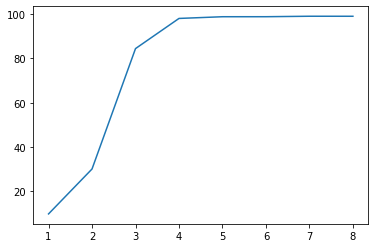

In [ ]:
import pandas as pd
acc_quants = pd.Series(accuracy_list,index=list(range(1,9)))
acc_quants.plot()  #다양한 num_bits에서의 정량화 정확도

위 그림에서 볼 수 있듯이 num_bits=4일 때 양자화는 기본적으로 최대 99%의 정확도에 도달한 것입니다.
이는 이 작은 모델을 저장하기 위해 fp32를 사용하는 것이 낭비임을 보여줍니다. int4를 사용하면 됩니다.

### 2.Quantitative aware training（QAT）

#### Issues with quantitative model training
양자화 모델에 의사양자화 노드를 삽입하여 역양자화와 양자화를 거친 후 양자화로 인해 발생하는 수치적 오류를 시뮬레이션할 수 있으며 실제로 저장되는 것은 역양자화 부동소수점 값입니다. 
그러나 계산 그래프에는 양자화 연산에 반올림 함수(반올림 함수)가 있고 이 함수의 기울기는 모든 곳에서 거의 0이기 때문에 이러한 모델은 여전히 ​​학습할 수 없습니다.
이러한 방식으로 역전파의 기울기가 0(체인 규칙)이 되고 훈련이 완료될 수 없게 됩니다.
우리는 이 문제를 해결하기 위해 STE를 사용할 수 있습니다.
#### Straight Through Estimator
STE 방법은 Fake 양자화 과정을 직접 건너뛰고 라운드 연산을 피하는 것입니다. Fake 양자화 이전에 컨벌루션 레이어의 기울기를 가중치로 직접 전파합니다. 이런 방식으로 컨볼루션에 사용된 가중치는 Fake 양자화 연산을 거쳤기 때문에 양자화 오류를 시뮬레이션할 수 있으며, 이러한 오류의 기울기를 원래 가중치로 반환하고, 발생한 오류에 맞게 가중치를 업데이트할 수 있습니다. 양자화를 통해 훈련을 정상적으로 계속할 수 있습니다.
핵심 포인트: 가중치의 의사 양자화는 오류를 발생시켜 모델 정확도를 감소시킵니다. 역전파를 통해 의사양자화 전 가중치에 기울기를 전달하고, 양자화로 인한 오차에 적응하기 위해 의사양자화 전 가중치를 업데이트한다. 이것은 양자화 인식 훈련입니다.

In [ ]:
# 정량화된 인식 훈련 과정은 일반적인 훈련 모델과 다르지 않습니다.
# 업데이트되는 것은 사전 양자화 가중치입니다. 
# Fake 양자화 연산은 양자화 오류를 도입하기 위해 순방향 전파에만 사용되며 가중치 자체는 수정하지 않습니다.
def quantize_aware_training(model, device, train_loader, optimizer, epoch):
    lossLayer = torch.nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader, 1):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.quantize_forward(data)
        loss = lossLayer(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print('Quantize Aware Training Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()
            ))

In [ ]:
# Perform quantitative perception training
from torch import optim
batch_size = 64
seed = 1
epochs = 3
lr = 0.01
momentum = 0.9
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, 
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=False
)

model_qat = copy.deepcopy(fp32_model)  #완전 정밀도 모델에서 양자화된 모델 얻기
model_qat.quantize(num_bits=3)
model_qat.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
model.train()
for epoch in range(epochs):
    quantize_aware_training(model_qat,device,train_loader,optimizer,epoch+1)
model.eval()
model.train() #freeze quantization parameters
quantize_inference(model, test_loader)


Quantize Aware Training Epoch: 1 [3200/60000]	Loss: 0.378004
Quantize Aware Training Epoch: 1 [6400/60000]	Loss: 0.275093
Quantize Aware Training Epoch: 1 [9600/60000]	Loss: 0.452319
Quantize Aware Training Epoch: 1 [12800/60000]	Loss: 0.252710
Quantize Aware Training Epoch: 1 [16000/60000]	Loss: 0.247085
Quantize Aware Training Epoch: 1 [19200/60000]	Loss: 0.270692
Quantize Aware Training Epoch: 1 [22400/60000]	Loss: 0.606104
Quantize Aware Training Epoch: 1 [25600/60000]	Loss: 0.255602
Quantize Aware Training Epoch: 1 [28800/60000]	Loss: 0.396091
Quantize Aware Training Epoch: 1 [32000/60000]	Loss: 0.635318
Quantize Aware Training Epoch: 1 [35200/60000]	Loss: 0.398860
Quantize Aware Training Epoch: 1 [38400/60000]	Loss: 0.422944
Quantize Aware Training Epoch: 1 [41600/60000]	Loss: 0.282550
Quantize Aware Training Epoch: 1 [44800/60000]	Loss: 0.285470
Quantize Aware Training Epoch: 1 [48000/60000]	Loss: 0.291429
Quantize Aware Training Epoch: 1 [51200/60000]	Loss: 0.372722
Quantize Aw

98.99

num_bits=3인 경우 QAT의 정확도는 84%에 불과한 반면 QAT는 99%의 정확도를 달성할 수 있습니다.
QAT는 낮은 비트 양자화를 향상시키는 데 더 많은 이점이 있습니다.